# Problem Set #5
### MACS 30100, Dr Evans
### Xi Chen

In [2]:
# Import needed stuff
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm
import scipy.interpolate as inter

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

## 1. Multinomial logistic regression and cross validation 

## (a) Use a multinomial logistic regression model

In [3]:
drink = pd.read_csv('strongdrink.txt')
drink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
y = drink[['cultivar']]

In [5]:
X = drink[['alco', 'malic', 'tot_phen', 'color_int']]
X.head()

,alco,malic,tot_phen,color_int
0,14.23,1.71,2.80,5.64
1,13.20,1.78,2.65,4.38
2,13.16,2.36,2.80,5.68
3,14.37,1.95,3.85,7.80
4,13.24,2.59,2.80,4.32


In [6]:
# Estimate the model on a 75% sample training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state=20) 

MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
estimates = MultLogReg.fit(X_train, y_train)

### Report the two sets of estimated coeﬃcients for j = 1 and j = 2

In [7]:
estimates.intercept_[0]

-24.010989451507836

In [8]:
estimates.coef_[0]

array([ 1.70040338, -0.26560523,  1.22389373,  0.02275637])

For j = 1, 
$\beta_{1, 0}$ = -24.01099, $\beta_{1, 1}$ = 1.7004, $\beta_{1, 2}$ = -0.2656, $\beta_{1, 3}$ = 1.2239, $\beta_{1, 4}$ = 0.0228.

In [9]:
estimates.intercept_[1]

22.80244619818977

In [10]:
estimates.coef_[1]

array([-1.46804432, -0.33305312,  0.66401185, -0.92271223])

For j = 2, 
$\beta_{2, 0}$ = 22.8024, $\beta_{2, 1}$ = -1.4680, $\beta_{2, 2}$ = -0.3331, $\beta_{2, 3}$ = 0.6640, $\beta_{2, 4}$ = -0.9227.

### Report the error rates (1 - precision) on the test set 

In [11]:
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))
print('Validation set MSE =', mean_squared_error(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

Validation set MSE = 0.0454545454545


The error rate for j = 1 is 0.13 (= 1 - 0.87). The error rate for j = 2 is 0 (= 1 - 1). The error rate for j = 3 is 0 (= 1 - 1). The validation set MSE is about 0.04545.

### Which category of cultivar is the model best at predicting? Is the most accurately predicted category the one with the most observations?

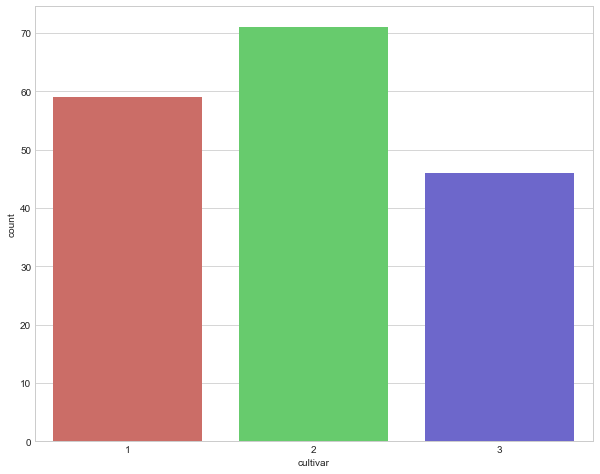

In [12]:
sb.countplot(x='cultivar', data=drink, palette='hls')

The error rates show that both of the category: j=2 and j=3, of $cultivar$ have good predictions. However, j=3 has better recall score than j=2. Besides, the countplot above shows that j=2 has the most observations while j=3 has the fewest observations. Therefore, the most accurately predicted category may not be the one with the most observations.

## (b) Perform a leave-one-out cross validation (LOOCV) with the model from part (a)

In [13]:
# Define loo as a leave-one-out object, then
# split it into N different partitions
Xvars = drink.ix[:, (1, 2, 6, 10)].values
yvals = drink.ix[:, 0].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
y_test_vec = np.zeros(N_loo)
y_pred_vec = np.zeros(N_loo)

# This loop will take 20 or 30 seconds
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test) 
    MSE_vec[test_index] = (y_test != y_pred).astype(int)
    y_pred_vec[test_index] = y_pred
    y_test_vec[test_index] = y_test

### Report the error rates (1 - precision) for each category. How do the error rates compare to those from part (a)?  Report the LOOCV estimate for the test MSE as the average MSE.

In [14]:
print(classification_report(y_test_vec, y_pred_vec))
print('The error rate for category 1 is', 1 - 0.90)
print('The error rate for category 2 is', 1 - 0.91)
print('The error rate for category 3 is', 1 - 0.96)
print('\n')
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('The test estimate MSE loocv =', MSE_loo,
      ', the test estimate MSE standard err =', MSE_loo_std)

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176

The error rate for category 1 is 0.09999999999999998
The error rate for category 2 is 0.08999999999999997
The error rate for category 3 is 0.040000000000000036


The test estimate MSE loocv = 0.0795454545455 , the test estimate MSE standard err = 0.270588202268


The error rate for category 1 is about 0.10 (= 1 - 0.90). The error rate for category 2 is about 0.09 (= 1 - 0.91). The error rate for category 3 is about 0.04 (= 1 - 0.96). The test estimate MSE is about 0.07955. Compared with part (a), the error rate for category 1 decresed to 0.10 from 0.13; the error rate for category 2 increased to 0.09 from 0.0; the error rate for category 3 increased to 0.04 from 0.0. The MSE increased to 0.0795 from 0.0455. 

## (c) Perform a k-fold cross validation in which the data are divided into k = 4 groups

### Report the error rates (1 - precision) for each category. How do your error rates compare to those from parts (a) and (b)? Report the k-fold estimate for the test MSE as the average MSE.

In [15]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    print('k index =', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    print(classification_report(y_test, y_pred))
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind,'is', MSE_vec_kf[k_ind])
    print('\n')
    k_ind += 1
    

k index = 0
             precision    recall  f1-score   support

          1       0.71      1.00      0.83        12
          2       1.00      0.75      0.86        24
          3       0.78      0.88      0.82         8

avg / total       0.88      0.84      0.84        44

MSE for test set 0 is 0.159090909091


k index = 1
             precision    recall  f1-score   support

          1       1.00      0.76      0.87        17
          2       0.69      1.00      0.81        11
          3       1.00      0.94      0.97        16

avg / total       0.92      0.89      0.89        44

MSE for test set 1 is 0.113636363636


k index = 2
             precision    recall  f1-score   support

          1       0.94      1.00      0.97        15
          2       0.94      0.94      0.94        16
          3       1.00      0.92      0.96        13

avg / total       0.96      0.95      0.95        44

MSE for test set 2 is 0.0454545454545


k index = 3
             precision    reca

In [16]:
print('The average error rate for category 1 is', 1 - (0.71 + 1.00 + 0.94 + 0.88)/4)
print('The average error rate for category 2 is', 1 - (1.00 + 0.69 + 0.94 + 1.00)/4)
print('The average error rate for category 3 is', 1 - (0.78 + 1.00 + 1.00 + 1.00)/4)

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('The test estimate MSE k-fold =', MSE_kf,
      ', the test estimate MSE standard err =', MSE_kf_std)

The average error rate for category 1 is 0.11750000000000005
The average error rate for category 2 is 0.09250000000000003
The average error rate for category 3 is 0.05499999999999994
The test estimate MSE k-fold = 0.0909090909091 , the test estimate MSE standard err = 0.04821182599


The error rate for category 1 is about 0.1175. The error rate for category 2 is about 0.0925. The error rate for category 3 is 0.0550. Compared to part (a), the error rates for category 1 are similar; the error rate for category 2 increased to 0.0925 from 0.0; the error rate for category 3 increased to 0.055 from 0.0. Compared with part (b), the error rates for category 1, 2, 3 are quite similar between part(c) and part(b). The k-fold estimate for the test MSE is 0.0909, with the standard error of 0.0482. 

## 2. Splines and interpolation

In [17]:
dt = pd.read_csv('CoolIndex.txt', header = None)
dt.columns = ['Age', 'Coolness']
dt.head()

,Age,Coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


## (a) Create a scatterplot of the data with age on the x-axis and Coolness Index on the y-axis

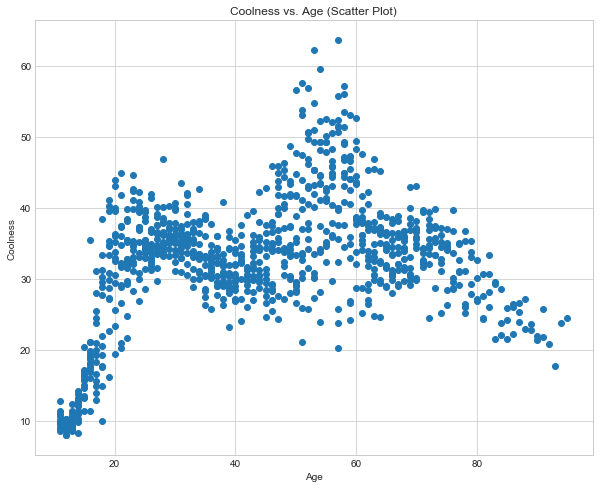

In [18]:
dt_age = dt.Age
dt_cool = dt.Coolness

plt.scatter(dt_age, dt_cool)
plt.xlabel('Age')
plt.ylabel('Coolness')
plt.title('Coolness vs. Age (Scatter Plot)')
plt.show()

## (b)  Use ordinary least squares (OLS) regression to ﬁt a stepwise function to these data. 

In [19]:
age = dt_age
cool = dt_cool

age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)

X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
X_step.describe()

,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.058577
std,0.368767,0.447326,0.451919,0.412812,0.234955
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
reg = sm.OLS(endog=cool, exog=X_step, missing='drop')
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:               Coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 19 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        00:11:08   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

### Report the estimated step function values for each bin [β1,β2,β3,β4,β5]. 

In [21]:
beta1, beta2, beta3, beta4, beta5 = reg_results.params
print('beta1 =', beta1, '\nbeta2 =', beta2, '\nbeta3=', beta3, 
      '\nbeta4=', beta4, '\nbeta5=', beta5)

beta1 = 20.1024572521 
beta2 = 34.4757880776 
beta3= 37.6351054924 
beta4= 35.2254000402 
beta5= 27.2963782443


### What is the predicted coolness of a 73-year old from the stepwise function?

In [22]:
#Since 73 is between 59 and 77, then the input should be [0,0,0,1,0]
a = reg_results.predict(exog=[0,0,0,1,0])[0]
print ('The predicted coolness of a 73-year old from the step function is', a)

The predicted coolness of a 73-year old from the step function is 35.2254000402


### Plot this step function on top of the scatterplot of the data from part (a). 

<function matplotlib.pyplot.show>

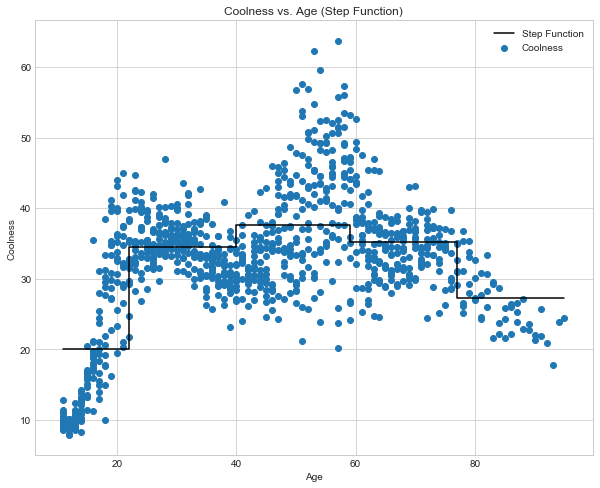

In [23]:
x = [11,22,40,59,77,95]
y = [beta1, beta1, beta2, beta3, beta4, beta5]

plt.step(x, y, color='black', label = 'Step Function')
plt.scatter(dt_age, dt_cool)
plt.xlabel('Age')
plt.ylabel('Coolness')
plt.title('Coolness vs. Age (Step Function)')
plt.legend(loc = 'upper right')
plt.show

## (c)  Fit a linear spline (continuous) to the data over the 5 age bins from part (b). 

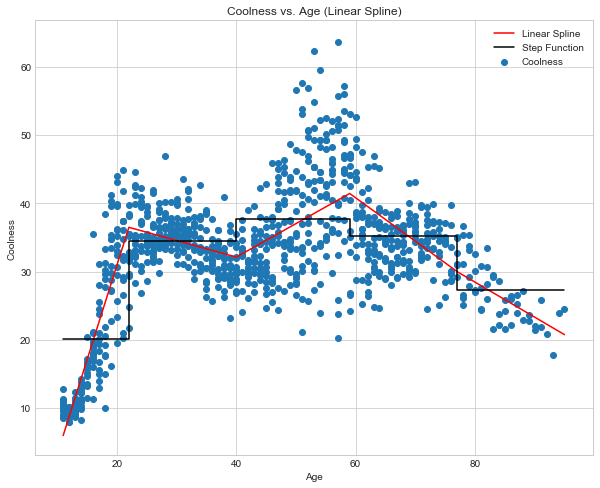

In [24]:
t = [22, 40, 59, 77]
linspl = inter.LSQUnivariateSpline(dt_age.values, dt_cool.values, t, k=1)
dist = np.linspace(11,95,1000)

plt.plot(dist, linspl(dist), color='r', label = 'Linear Spline')
plt.step(x, y, color='black', label = 'Step Function')
plt.scatter(dt_age, dt_cool)
plt.xlabel('Age')
plt.ylabel('Coolness')
plt.title('Coolness vs. Age (Linear Spline)')
plt.legend(loc = 'upper right')
plt.show()

### What is the predicted coolness of a 73-year old from the linear spline?

In [25]:
print('The predicted coolness of a 73-year old from the linear spline is', linspl(73))

The predicted coolness of a 73-year old from the linear spline is 32.536832389143306


## (d)  Fit a cubic spline (continuous) to the data over the 5 age bins from part (b). 

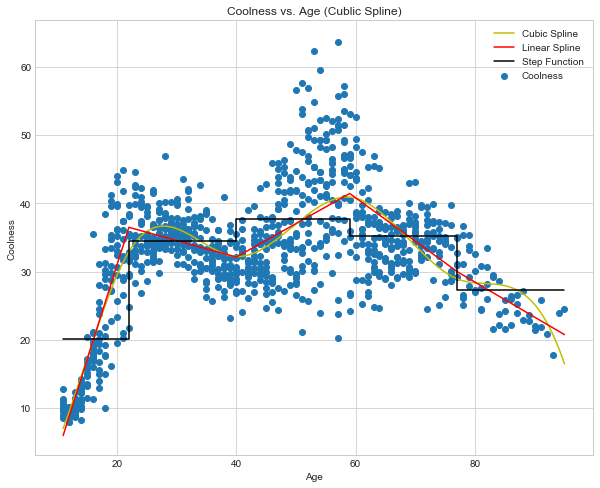

In [26]:
cubspl = inter.LSQUnivariateSpline(dt_age.values, dt_cool.values, t, k=3)

plt.plot(dist, cubspl(dist), color='y', label = 'Cubic Spline')
plt.plot(dist, linspl(dist), color='r', label = 'Linear Spline')
plt.step(x, y, color='black', label = 'Step Function')
plt.scatter(dt_age, dt_cool)
plt.xlabel('Age')
plt.ylabel('Coolness')
plt.title('Coolness vs. Age (Cublic Spline)')
plt.legend(loc = 'upper right')
plt.show()

### What is the predicted coolness of a 73-year old from the cubic spline?

In [27]:
print('The predicted coolness of a 73-year old from the cubic spline is', cubspl(73))

The predicted coolness of a 73-year old from the cubic spline is 31.262429389257864
